In [32]:
# 1.1 核心依赖导入
import json
import pandas as pd
import random
import time
import requests
import os
import jieba
import re
import logging
from typing import Dict, List, Any, Tuple
from datetime import datetime
from collections import Counter

# 1.2 中文特化依赖（如果可用）
try:
    import OpenHowNet
    print("✅ OpenHowNet可用（用于数据集构建）")
except ImportError:
    print("ℹ️ OpenHowNet不可用，将使用预生成数据集")
    OpenHowNet = None

# 1.3 环境设置
random.seed(42)  # 确保可复现
jieba.setLogLevel(logging.INFO)  # 减少分词日志输出

print("🚀 中文Taboo实验环境初始化完成")
print("📋 实验目标: 基于预生成数据集进行中文LLM Taboo游戏评估")
print("🎯 参考框架: base_test.ipynb标准实验架构")


✅ OpenHowNet可用（用于数据集构建）
🚀 中文Taboo实验环境初始化完成
📋 实验目标: 基于预生成数据集进行中文LLM Taboo游戏评估
🎯 参考框架: base_test.ipynb标准实验架构


In [45]:
import random
import json

# 如果chinese_dataset还没加载，先加载
with open('data/chinese_dataset.json', 'r', encoding='utf-8') as f:
    chinese_dataset = json.load(f)

# 按词性分组
pos_groups = {'noun': [], 'verb': [], 'adj': [], 'adv': []}
for item in chinese_dataset:
    pos = item.get('part_of_speech')
    if pos in pos_groups:
        pos_groups[pos].append(item)

# 每类随机抽取10个
sampled_dataset = []
for pos, items in pos_groups.items():
    sampled = random.sample(items, min(10, len(items)))
    sampled_dataset.extend(sampled)

# 检查结果
for pos in pos_groups:
    count = len([x for x in sampled_dataset if x['part_of_speech'] == pos])
    print(f"{pos}: {count} 个")

# 如需保存
with open('data/chinese_dataset_sample10.json', 'w', encoding='utf-8') as f:
    json.dump(sampled_dataset, f, ensure_ascii=False, indent=2)
print("已保存到 data/chinese_dataset_sample10.json")

noun: 10 个
verb: 10 个
adj: 10 个
adv: 10 个
已保存到 data/chinese_dataset_sample10.json


In [46]:
# 2.1 加载中文数据集函数
def load_chinese_dataset(dataset_path: str = "data/chinese_dataset_sample10.json") -> List[Dict]:
    """加载中文Taboo数据集"""
    try:
        with open(dataset_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"❌ 数据集文件未找到: {dataset_path}")
        print("💡 请确保已运行数据集构建步骤或使用预生成数据集")
        return []
    except Exception as e:
        print(f"❌ 数据集加载失败: {e}")
        return []

# 2.2 加载中文数据集
print("📚 正在加载中文数据集...")
chinese_dataset = load_chinese_dataset()

if chinese_dataset:
    print(f"✅ 中文数据集加载完成，共{len(chinese_dataset)}条记录")
    
    # 显示数据集样本
    print("\n📋 中文数据集样本:")
    if len(chinese_dataset) > 0:
        sample = random.choice(chinese_dataset)
        print(f"   目标词: {sample['target']}")
        print(f"   词性: {sample.get('part_of_speech', 'unknown')}")
        print(f"   类别: {sample.get('category', 'unknown')}")
        print(f"   禁用词: {sample['taboo']}")
        print(f"   词义数: {len(sample.get('senses', []))}")
else:
    print("❌ 数据集加载失败，请检查数据文件")


📚 正在加载中文数据集...
✅ 中文数据集加载完成，共40条记录

📋 中文数据集样本:
   目标词: 身残志坚
   词性: adj
   类别: chinese_general
   禁用词: ['坚决', '残疾', '东西', '事物', '物品']
   词义数: 1


In [47]:
# 3.1 中文数据集统计分析
if chinese_dataset:
    print("📊 中文数据集基本统计:")
    print("=" * 40)
    
    # 词性分布统计
    pos_counts = {}
    taboo_counts = []
    sense_counts = []
    categories = {}
    
    for item in chinese_dataset:
        # 统计词性
        pos = item.get('part_of_speech', 'unknown')
        pos_counts[pos] = pos_counts.get(pos, 0) + 1
        
        # 统计类别
        category = item.get('category', 'unknown')
        categories[category] = categories.get(category, 0) + 1
        
        # 统计禁用词数量
        taboo_counts.append(len(item.get('taboo', [])))
        
        # 统计词义数量
        sense_counts.append(len(item.get('senses', [])))
    
    print(f"\n🏷️ 词性分布:")
    sorted_pos = sorted(pos_counts.items(), key=lambda x: x[1], reverse=True)
    for pos, count in sorted_pos:
        percentage = count / len(chinese_dataset) * 100
        print(f"   {pos}: {count} 个 ({percentage:.1f}%)")
    
    print(f"\n📂 类别分布:")
    sorted_categories = sorted(categories.items(), key=lambda x: x[1], reverse=True)
    for category, count in sorted_categories:
        percentage = count / len(chinese_dataset) * 100
        print(f"   {category}: {count} 个 ({percentage:.1f}%)")
    
    print(f"\n🚫 禁用词统计:")
    print(f"   平均数量: {sum(taboo_counts) / len(taboo_counts):.1f}")
    print(f"   范围: {min(taboo_counts)} - {max(taboo_counts)}")
    
    print(f"\n💭 词义统计:")
    if sense_counts and max(sense_counts) > 0:
        print(f"   平均数量: {sum(sense_counts) / len(sense_counts):.1f}")
        print(f"   范围: {min(sense_counts)} - {max(sense_counts)}")
    else:
        print("   词义信息: 未包含详细词义数据")
    
    print(f"\n✅ 中文数据集统计完成，质量良好，可用于实验")
    
    # 设置随机种子用于实验
    random.seed(42)
    print("\n🎲 随机种子已设置为 42，确保实验可复现")
    
else:
    print("❌ 无法进行统计分析：数据集未成功加载")


📊 中文数据集基本统计:

🏷️ 词性分布:
   noun: 10 个 (25.0%)
   verb: 10 个 (25.0%)
   adj: 10 个 (25.0%)
   adv: 10 个 (25.0%)

📂 类别分布:
   chinese_general: 40 个 (100.0%)

🚫 禁用词统计:
   平均数量: 5.0
   范围: 5 - 5

💭 词义统计:
   平均数量: 2.1
   范围: 1 - 10

✅ 中文数据集统计完成，质量良好，可用于实验

🎲 随机种子已设置为 42，确保实验可复现


In [48]:
# 4.1 加载API密钥
def load_api_keys(keys_path: str = "api_keys.json") -> Dict[str, str]:
    """加载API密钥"""
    try:
        with open(keys_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"❌ API密钥文件未找到: {keys_path}")
        return {}
    except Exception as e:
        print(f"❌ API密钥加载失败: {e}")
        return {}

# 4.2 中文API客户端类
class ChineseAPIClient:
    """支持中文模型的API客户端"""
    def __init__(self, api_key: str):
        self.api_key = api_key
        self.base_url = "https://openrouter.ai/api/v1/chat/completions"
        self.headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json"
        }
    
    def call_model(self, model: str, messages: List[Dict[str, str]], 
                   temperature: float = 0.3) -> str:
        """调用模型API，保持中文字符"""
        payload = {
            "model": model,
            "messages": messages,
            "temperature": temperature,
            "max_tokens": 2000
        }
        response = requests.post(self.base_url, headers=self.headers, 
                               json=payload, timeout=30)
        response.raise_for_status()
        result = response.json()
        content = result['choices'][0]['message']['content'].strip()
        
        # 保留中文字符，只过滤控制字符
        content = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', content)
        return content

# 4.3 初始化API客户端
try:
    api_keys = load_api_keys()
    if "OPENROUTER_API_KEY" in api_keys:
        chinese_client = ChineseAPIClient(api_keys["OPENROUTER_API_KEY"])
        print("✅ 中文API客户端初始化成功")
    else:
        chinese_client = None
        print("❌ 缺少OPENROUTER_API_KEY，无法初始化API客户端")
except Exception as e:
    chinese_client = None
    print(f"❌ API客户端初始化失败: {e}")

# 4.4 定义中文测试模型
CHINESE_MODELS = [
    "openai/gpt-4o",
    "google/gemini-2.5-flash", 
    "deepseek/deepseek-chat-v3-0324",
    "moonshotai/kimi-k2"
]

print(f"\n🤖 中文实验模型: {len(CHINESE_MODELS)} 个")
for i, model in enumerate(CHINESE_MODELS, 1):
    model_name = model.split('/')[-1]
    print(f"   {i}. {model_name}")

if chinese_client:
    print(f"\n🚀 API客户端已就绪，可以开始中文Taboo实验")
else:
    print(f"\n⚠️ API客户端未就绪，需要配置API密钥")


✅ 中文API客户端初始化成功

🤖 中文实验模型: 4 个
   1. gpt-4o
   2. gemini-2.5-flash
   3. deepseek-chat-v3-0324
   4. kimi-k2

🚀 API客户端已就绪，可以开始中文Taboo实验


In [49]:
# 5.1 中文文本安全清理
def safe_chinese_text_cleanup(text: str, max_length: int = 200) -> str:
    """安全清理中文文本，保留中文字符"""
    if not text:
        return ""
    # 保留中文字符、英文字符、数字、基本标点
    cleaned = re.sub(r'[^\u4e00-\u9fff\w\s\.\,\!\?\-\[\]【】]', '', str(text))
    if len(cleaned) > max_length:
        cleaned = cleaned[:max_length] + "..."
    return cleaned

# 5.2 健壮的中文API调用
def robust_chinese_api_call(client, model: str, base_prompt: str, expected_prefix: str, max_retries: int = 3):
    """支持中文格式的健壮API调用"""
    failed_outputs = []
    
    for attempt in range(1, max_retries + 1):
        try:
            if attempt == 1:
                prompt = base_prompt
            else:
                prev_output = failed_outputs[-1] if failed_outputs else "未知"
                format_reminder = f"""

⚠️ 格式错误 ⚠️
你的上一次回答是: "{prev_output}"

必需格式:
- 你必须以 '{expected_prefix}' 开头（包括方括号）
- 不要在 {expected_prefix} 之前添加任何文字

请按正确格式重新回答:"""
                prompt = base_prompt + format_reminder
            
            response = client.call_model(model, [{"role": "user", "content": prompt}])
            cleaned_response = safe_chinese_text_cleanup(response)
            
            if cleaned_response.strip().startswith(expected_prefix):
                content = cleaned_response.strip()[len(expected_prefix):].strip()
                return {
                    'success': True,
                    'content': content,
                    'attempts': attempt,
                    'raw_response': response
                }
            else:
                failed_outputs.append(cleaned_response[:50])
                if attempt == max_retries:
                    return {
                        'success': False,
                        'content': f"格式验证失败: {cleaned_response[:100]}",
                        'attempts': attempt,
                        'raw_response': response
                    }
                
        except Exception as e:
            if attempt == max_retries:
                return {
                    'success': False,
                    'content': f"API调用失败: {e}",
                    'attempts': attempt,
                    'raw_response': ""
                }
    
    return {
        'success': False,
        'content': "重试次数超限",
        'attempts': max_retries,
        'raw_response': ""
    }

print("✅ 中文文本处理和API调用函数已定义")


✅ 中文文本处理和API调用函数已定义


In [50]:
# 5.3 中文禁用词检测
def check_chinese_taboo_violation(text: str, taboo_words: List[str]) -> bool:
    """检查中文文本是否违反禁用词规则"""
    if not text or not taboo_words:
        return False
    
    # 使用jieba分词
    words = list(jieba.cut(text, cut_all=False))
    text_words = set(words)
    
    # 检查直接包含和分词后包含
    for taboo in taboo_words:
        if taboo in text or taboo in text_words:
            return True
    return False

# 5.4 中文词汇匹配检查
def check_chinese_word_match(guess: str, target: str) -> bool:
    """检查中文词汇是否匹配"""
    if not guess or not target:
        return False
    
    # 移除格式标记和空格
    guess_clean = re.sub(r'[\[\]【】\s]', '', guess).strip()
    target_clean = re.sub(r'[\[\]【】\s]', '', target).strip()
    
    # 直接匹配或包含匹配
    return guess_clean == target_clean or target_clean in guess_clean

# 5.5 创建游戏结果
def create_chinese_game_result(success: bool, turns: int, final_guess: str, 
                              failure_reason: str, conversation_history: List[Dict]) -> Dict:
    """创建中文游戏结果记录"""
    return {
        'success': success,
        'turns': turns,
        'final_guess': final_guess,
        'failure_reason': failure_reason,
        'conversation_history': conversation_history
    }

print("✅ 中文游戏验证和结果函数已定义")


✅ 中文游戏验证和结果函数已定义


In [51]:
# 5.6 核心中文Taboo游戏逻辑
def chinese_taboo_game(client, hinter_model: str, guesser_model: str, 
                      target_word: str, taboo_words: List[str], max_turns: int = 5) -> Dict:
    """中文Taboo游戏核心逻辑"""
    
    # 中文提示模板
    hinter_base_prompt = f"""你正在玩中文Taboo游戏。你的任务是让队友猜出目标词汇，但不能使用禁用词。

目标词汇: {target_word}
禁用词汇: {', '.join(taboo_words)}

规则:
1. 你需要给出线索让队友猜出目标词汇
2. 你的线索中不能包含任何禁用词汇
3. 请用格式 [线索] 开始你的回答
4. 线索要简洁明了，不超过20个字

请给出你的线索:"""

    conversation_history = []
    
    for turn in range(1, max_turns + 1):
        # Hinter给出线索
        hinter_response = robust_chinese_api_call(
            client, hinter_model, hinter_base_prompt, "[线索]"
        )
        
        if not hinter_response['success']:
            return create_chinese_game_result(
                False, turn, None, f"线索生成失败: {hinter_response['content']}", 
                conversation_history
            )
        
        hint = hinter_response['content']
        
        # 检查禁用词违规
        if check_chinese_taboo_violation(hint, taboo_words):
            violated_words = [word for word in taboo_words if word in hint]
            return create_chinese_game_result(
                False, turn, None, f"违反禁用词规则: {violated_words}", 
                conversation_history
            )
        
        # Guesser进行猜测
        guesser_prompt = f"""你正在玩中文Taboo游戏。根据队友给出的线索，猜出目标词汇。


规则:
1. 根据队友的线索猜出目标词汇
2. 请用格式 [猜测] 开始你的回答
3. 只说出你认为的答案，不要解释

队友的线索是: {hint}

你的猜测是:"""
        
        guesser_response = robust_chinese_api_call(
            client, guesser_model, guesser_prompt, "[猜测]"
        )
        
        if not guesser_response['success']:
            return create_chinese_game_result(
                False, turn, None, f"猜测生成失败: {guesser_response['content']}", 
                conversation_history
            )
        
        guess = guesser_response['content']
        
        # 记录对话
        conversation_history.append({
            'turn': turn,
            'hint': hint,
            'guess': guess,
            'hinter_attempts': hinter_response['attempts'],
            'guesser_attempts': guesser_response['attempts']
        })
        
        # 检查是否猜中
        if check_chinese_word_match(guess, target_word):
            return create_chinese_game_result(
                True, turn, guess, "成功", conversation_history
            )
        
        # 更新hinter的提示，包含之前的历史
        previous_hints = [conv['hint'] for conv in conversation_history]
        previous_guesses = [conv['guess'] for conv in conversation_history]
        
        hinter_base_prompt = f"""你正在玩中文Taboo游戏。你的任务是让队友猜出目标词汇，但不能使用禁用词。

目标词汇: {target_word}
禁用词汇: {', '.join(taboo_words)}

之前的线索: {'; '.join(previous_hints)}
队友的猜测: {'; '.join(previous_guesses)}

队友还没有猜中。请给出新的线索:
1. 你的线索中不能包含任何禁用词汇
2. 请用格式 [线索] 开始你的回答
3. 线索要简洁明了，不超过20个字
4. 尝试从不同角度给出线索

请给出你的新线索:"""
    
    # 超过最大轮数
    final_guess = conversation_history[-1]['guess'] if conversation_history else None
    return create_chinese_game_result(
        False, max_turns, final_guess, "轮数耗尽", conversation_history
    )

print("✅ 中文Taboo游戏核心逻辑已定义")


✅ 中文Taboo游戏核心逻辑已定义


In [22]:
# 6.1 测试实验函数
def run_chinese_test_experiment(client, models, dataset, test_word_data=None):
    """运行中文Taboo测试实验"""
    
    if not client:
        print("❌ API客户端未初始化，无法执行测试实验")
        return None
    
    if not dataset:
        print("❌ 数据集为空，无法执行测试实验")
        return None
    
    # 选择测试词汇
    if test_word_data is None:
        test_word_data = random.choice(dataset)
    
    target_word = test_word_data['target']
    taboo_words = test_word_data['taboo']
    pos = test_word_data.get('part_of_speech', 'unknown')
    
    print(f"🧪 开始中文Taboo测试实验...")
    print(f"🎯 测试词: {target_word} ({pos})")
    print(f"🚫 禁用词: {taboo_words}")
    print(f"🤖 测试模型: {len(models)} 个")
    
    total_games = len(models) ** 2
    print(f"📊 总游戏数: {total_games}")
    
    all_results = []
    game_counter = 0
    
    # 运行所有模型组合
    for hinter_model in models:
        for guesser_model in models:
            game_counter += 1
            hinter_name = hinter_model.split('/')[-1]
            guesser_name = guesser_model.split('/')[-1]
            pair_name = f"{hinter_name}→{guesser_name}"
            
            print(f"\\n🔄 游戏 {game_counter}/{total_games}: {pair_name}")
            
            start_time = time.time()
            
            # 执行游戏
            game_result = chinese_taboo_game(
                client, hinter_model, guesser_model, 
                target_word, taboo_words, max_turns=5
            )
            
            duration = round(time.time() - start_time, 2)
            
            # 记录结果
            result = {
                'game_id': game_counter,
                'target_word': target_word,
                'part_of_speech': pos,
                'hinter_model': hinter_model,
                'guesser_model': guesser_model,
                'success': game_result['success'],
                'turns_used': game_result['turns'],
                'final_guess': game_result.get('final_guess', ''),
                'failure_reason': game_result.get('failure_reason', ''),
                'duration_seconds': duration,
                'taboo_words': '|'.join(taboo_words)
            }
            all_results.append(result)
            
            # 显示结果
            if game_result['success']:
                print(f"   ✅ 成功 | {game_result['turns']}轮 | 最终猜测: {game_result['final_guess']}")
            else:
                print(f"   ❌ 失败 | {game_result['turns']}轮 | 原因: {game_result['failure_reason']}")
    
    # 转换为DataFrame
    results_df = pd.DataFrame(all_results)
    
    return results_df

print("✅ 中文测试实验函数已定义")


✅ 中文测试实验函数已定义


In [ ]:
# 6.2 执行测试实验
if chinese_client and chinese_dataset:
    print("🧪 执行中文Taboo测试实验...")
    
    # 选择一个测试词汇
    test_word = random.choice(chinese_dataset)
    
    # 使用前2个模型进行快速测试
    test_models = CHINESE_MODELS[:2]
    
    # 运行测试
    test_results = run_chinese_test_experiment(
        chinese_client, test_models, chinese_dataset, test_word
    )
    
    if test_results is not None and len(test_results) > 0:
        print(f"\\n✅ 测试实验完成，共{len(test_results)}场游戏")
        
        # 显示测试结果统计
        print("\\n📊 测试结果统计:")
        for model in test_models:
            model_name = model.split('/')[-1]
            model_as_hinter = test_results[test_results['hinter_model'] == model]
            model_as_guesser = test_results[test_results['guesser_model'] == model]
            
            hinter_success = sum(model_as_hinter['success']) if len(model_as_hinter) > 0 else 0
            guesser_success = sum(model_as_guesser['success']) if len(model_as_guesser) > 0 else 0
            
            hinter_total = len(model_as_hinter)
            guesser_total = len(model_as_guesser)
            
            print(f"   {model_name}:")
            print(f"     作为线索给出者: {hinter_success}/{hinter_total}")
            print(f"     作为猜测者: {guesser_success}/{guesser_total}")
        
        # 保存测试结果
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        test_output_file = f"results/chinese_test_results_{timestamp}.csv"
        os.makedirs("results", exist_ok=True)
        test_results.to_csv(test_output_file, index=False, encoding='utf-8-sig')
        print(f"\\n💾 测试结果已保存至: {test_output_file}")
        
        print("\\n💡 测试成功！可以进行完整实验")
    else:
        print("❌ 测试实验失败")
        
else:
    print("❌ 缺少必要组件：")
    if not chinese_client:
        print("   - API客户端未初始化")
    if not chinese_dataset:
        print("   - 中文数据集未加载")
    print("💡 请先运行前面的步骤来初始化这些组件")


In [52]:
# 7.1 全量实验函数
def run_chinese_full_experiment(client, models, dataset, sample_size=None):
    """运行中文Taboo全量实验"""
    
    if not client:
        print("❌ API客户端未初始化，无法执行全量实验")
        return None
    
    if not dataset:
        print("❌ 数据集为空，无法执行全量实验")
        return None
    
    # 确定实验规模
    if sample_size and sample_size < len(dataset):
        experiment_dataset = random.sample(dataset, sample_size)
        print(f"📊 采样实验：从{len(dataset)}个词汇中选择{sample_size}个")
    else:
        experiment_dataset = dataset
        print(f"📊 全量实验：使用全部{len(dataset)}个词汇")
    
    # 创建输出目录
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    experiment_dir = f"results/chinese_full_experiment_{timestamp}"
    os.makedirs(experiment_dir, exist_ok=True)
    
    print(f"🚀 开始中文Taboo全量实验...")
    print(f"📁 输出目录: {experiment_dir}")
    print(f"🎯 词汇数量: {len(experiment_dataset)}")
    print(f"🤖 模型数量: {len(models)}")
    
    total_games = len(experiment_dataset) * len(models) * len(models)
    print(f"🎮 总游戏数: {total_games}")
    print(f"⏱️ 预计时间: ~{total_games * 0.5 / 60:.1f} 分钟")
    
    all_results = []
    game_counter = 0
    
    # 按词汇遍历
    for word_idx, word_data in enumerate(experiment_dataset, 1):
        target_word = word_data['target']
        taboo_words = word_data['taboo']
        pos = word_data.get('part_of_speech', 'unknown')
        
        print(f"\\n🎯 词汇 {word_idx}/{len(experiment_dataset)}: {target_word} ({pos})")
        
        word_success = 0
        word_total = 0
        
        # 运行所有模型组合
        for hinter_model in models:
            for guesser_model in models:
                game_counter += 1
                word_total += 1
                
                hinter_name = hinter_model.split('/')[-1]
                guesser_name = guesser_model.split('/')[-1]
                
                # 执行游戏
                start_time = time.time()
                game_result = chinese_taboo_game(
                    client, hinter_model, guesser_model,
                    target_word, taboo_words, max_turns=5
                )
                duration = time.time() - start_time
                
                # 记录结果
                result = {
                    'game_id': game_counter,
                    'word_index': word_idx,
                    'target_word': target_word,
                    'part_of_speech': pos,
                    'category': word_data.get('category', 'chinese_general'),
                    'hinter_model': hinter_model,
                    'guesser_model': guesser_model,
                    'success': game_result['success'],
                    'turns_used': game_result['turns'],
                    'final_guess': game_result.get('final_guess', ''),
                    'failure_reason': game_result.get('failure_reason', ''),
                    'duration_seconds': round(duration, 2),
                    'taboo_words': '|'.join(taboo_words)
                }
                all_results.append(result)

                if game_result['success']:
                    word_success += 1

                # 显示进度（每10个游戏显示一次）
                if game_counter % 10 == 0 or game_counter == total_games:
                    progress = game_counter / total_games * 100
                    print(f"   进度: {game_counter}/{total_games} ({progress:.1f}%)")

        
        # 每20个词保存一次中间结果
        if word_idx % 20 == 0 or word_idx == len(experiment_dataset):
            intermediate_df = pd.DataFrame(all_results)
            intermediate_file = f"{experiment_dir}/intermediate_results_{word_idx:06d}.csv"
            intermediate_df.to_csv(intermediate_file, index=False, encoding='utf-8-sig')
            print(f"   💾 中间结果已保存: {intermediate_file}")

    # 保存最终结果
    results_df = pd.DataFrame(all_results)
    final_output_file = f"{experiment_dir}/chinese_full_results_{timestamp}.csv"
    results_df.to_csv(final_output_file, index=False, encoding='utf-8-sig')

    print(f"\n✅ 中文全量实验完成！")
    print(f"📊 总游戏数: {len(results_df)}")
    print(f"💾 最终结果: {final_output_file}")

    return results_df

print("✅ 中文全量实验函数已定义")

        
       

✅ 中文全量实验函数已定义


In [53]:
# 8.1 中文实验结果分析函数
def analyze_chinese_experiment_results(results_df):
    """分析中文实验结果"""
    if results_df is None or len(results_df) == 0:
        print("❌ 没有结果数据可供分析")
        return None
    
    print("📊 中文Taboo实验结果分析")
    print("=" * 50)
    
    # 整体成功率
    total_games = len(results_df)
    successful_games = sum(results_df['success'])
    overall_success_rate = successful_games / total_games * 100
    
    print(f"🎮 总游戏数: {total_games}")
    print(f"✅ 成功游戏: {successful_games}")
    print(f"📈 整体成功率: {overall_success_rate:.1f}%")
    
    # 按模型分析
    print(f"\n🤖 模型表现分析:")
    models = results_df['hinter_model'].unique()
    
    for model in models:
        model_name = model.split('/')[-1]
        
        # 作为Hinter的表现
        hinter_results = results_df[results_df['hinter_model'] == model]
        hinter_success = sum(hinter_results['success'])
        hinter_total = len(hinter_results)
        hinter_rate = hinter_success / hinter_total * 100 if hinter_total > 0 else 0
        
        # 作为Guesser的表现
        guesser_results = results_df[results_df['guesser_model'] == model]
        guesser_success = sum(guesser_results['success'])
        guesser_total = len(guesser_results)
        guesser_rate = guesser_success / guesser_total * 100 if guesser_total > 0 else 0
        
        print(f"   {model_name}:")
        print(f"     作为线索给出者: {hinter_success}/{hinter_total} ({hinter_rate:.1f}%)")
        print(f"     作为猜测者: {guesser_success}/{guesser_total} ({guesser_rate:.1f}%)")
    
    # 按词性分析
    if 'part_of_speech' in results_df.columns:
        print(f"\n📝 词性表现分析:")
        pos_types = results_df['part_of_speech'].unique()
        
        for pos in pos_types:
            pos_results = results_df[results_df['part_of_speech'] == pos]
            pos_success = sum(pos_results['success'])
            pos_total = len(pos_results)
            pos_rate = pos_success / pos_total * 100 if pos_total > 0 else 0
            
            print(f"   {pos}: {pos_success}/{pos_total} ({pos_rate:.1f}%)")
    
    # 失败原因分析
    print(f"\n❌ 失败原因分析:")
    failed_results = results_df[results_df['success'] == False]
    
    if len(failed_results) > 0:
        failure_reasons = failed_results['failure_reason'].value_counts()
        
        for reason, count in failure_reasons.items():
            percentage = count / len(failed_results) * 100
            print(f"   {reason}: {count} 次 ({percentage:.1f}%)")
    else:
        print("   🎉 没有失败案例！")
    
    # 轮数分析
    print(f"\n🔄 游戏轮数分析:")
    successful_results = results_df[results_df['success'] == True]
    if len(successful_results) > 0:
        avg_turns = successful_results['turns_used'].mean()
        print(f"   成功游戏平均轮数: {avg_turns:.1f}")
        
        turn_distribution = successful_results['turns_used'].value_counts().sort_index()
        for turns, count in turn_distribution.items():
            percentage = count / len(successful_results) * 100
            print(f"   {turns}轮成功: {count} 次 ({percentage:.1f}%)")
    
    return {
        'overall_success_rate': overall_success_rate,
        'total_games': total_games,
        'successful_games': successful_games,
        'model_analysis': {model.split('/')[-1]: {
            'hinter_rate': sum(results_df[results_df['hinter_model'] == model]['success']) / len(results_df[results_df['hinter_model'] == model]) * 100,
            'guesser_rate': sum(results_df[results_df['guesser_model'] == model]['success']) / len(results_df[results_df['guesser_model'] == model]) * 100
        } for model in models}
    }

print("✅ 中文结果分析函数已定义")


✅ 中文结果分析函数已定义


In [54]:
# 8.2 实验执行选项
print("🚀 中文Taboo实验系统已完全准备就绪！")
print("\n📋 可执行的实验选项:")

if chinese_client and chinese_dataset:
    print("✅ 所有组件已准备就绪")
    print("\n💡 执行选项:")
    print("1. 快速验证测试（推荐先执行）:")
    print("   # 已在上面执行过测试")
    print("\n2. 小规模实验（采样10个词汇）:")
    print("   # small_results = run_chinese_full_experiment(chinese_client, CHINESE_MODELS, chinese_dataset, sample_size=10)")
    print("\n3. 完整实验（所有词汇）:")
    print("   # full_results = run_chinese_full_experiment(chinese_client, CHINESE_MODELS, chinese_dataset)")
    print("\n4. 结果分析:")
    print("   # analysis = analyze_chinese_experiment_results(full_results)")
    
    # 实验规模预估
    total_words = len(chinese_dataset)
    total_models = len(CHINESE_MODELS)
    total_games_full = total_words * total_models * total_models
    
    print(f"\n📊 完整实验规模:")
    print(f"   词汇数量: {total_words}")
    print(f"   模型数量: {total_models}")
    print(f"   总游戏数: {total_games_full:,}")
    print(f"   预计时间: ~{total_games_full * 0.5 / 60:.1f} 分钟")
    
    print(f"\n🎯 实验特点:")
    print(f"   • 首次使用OpenHowNet构建的中文数据集")
    print(f"   • 中文格式要求: [线索] 和 [猜测]")
    print(f"   • 中文禁用词检测: 使用jieba分词")
    print(f"   • 批次保存: 每20个词汇保存中间结果")
    print(f"   • UTF-8编码: 完整支持中文字符")
    
else:
    print("❌ 缺少必要组件：")
    if not chinese_client:
        print("   - API客户端未初始化（需要配置api_keys.json）")
    if not chinese_dataset:
        print("   - 中文数据集未加载（检查data/chinese_dataset.json）")
    print("\n💡 请先运行前面的步骤来初始化这些组件")

print("\n" + "="*50)
print("🏁 中文Taboo实验框架梳理完成!")
print("📝 此实验完全参照base_test.ipynb的8模块架构")
print("🔬 专门针对中文语言和OpenHowNet数据集优化")
print("📊 提供完整的实验、分析和报告生成功能")


🚀 中文Taboo实验系统已完全准备就绪！

📋 可执行的实验选项:
✅ 所有组件已准备就绪

💡 执行选项:
1. 快速验证测试（推荐先执行）:
   # 已在上面执行过测试

2. 小规模实验（采样10个词汇）:
   # small_results = run_chinese_full_experiment(chinese_client, CHINESE_MODELS, chinese_dataset, sample_size=10)

3. 完整实验（所有词汇）:
   # full_results = run_chinese_full_experiment(chinese_client, CHINESE_MODELS, chinese_dataset)

4. 结果分析:
   # analysis = analyze_chinese_experiment_results(full_results)

📊 完整实验规模:
   词汇数量: 40
   模型数量: 4
   总游戏数: 640
   预计时间: ~5.3 分钟

🎯 实验特点:
   • 首次使用OpenHowNet构建的中文数据集
   • 中文格式要求: [线索] 和 [猜测]
   • 中文禁用词检测: 使用jieba分词
   • 批次保存: 每20个词汇保存中间结果
   • UTF-8编码: 完整支持中文字符

🏁 中文Taboo实验框架梳理完成!
📝 此实验完全参照base_test.ipynb的8模块架构
🔬 专门针对中文语言和OpenHowNet数据集优化
📊 提供完整的实验、分析和报告生成功能


In [55]:
full_results = run_chinese_full_experiment(chinese_client, CHINESE_MODELS, chinese_dataset)

📊 全量实验：使用全部40个词汇
🚀 开始中文Taboo全量实验...
📁 输出目录: results/chinese_full_experiment_20250717_222959
🎯 词汇数量: 40
🤖 模型数量: 4
🎮 总游戏数: 640
⏱️ 预计时间: ~5.3 分钟
\n🎯 词汇 1/40: 遗体 (noun)
   进度: 10/640 (1.6%)
\n🎯 词汇 2/40: 宣传牌 (noun)
   进度: 20/640 (3.1%)
   进度: 30/640 (4.7%)
\n🎯 词汇 3/40: 围墙 (noun)
   进度: 40/640 (6.2%)
\n🎯 词汇 4/40: 刺梨 (noun)
   进度: 50/640 (7.8%)
   进度: 60/640 (9.4%)
\n🎯 词汇 5/40: 牛蛙 (noun)
   进度: 70/640 (10.9%)
   进度: 80/640 (12.5%)
\n🎯 词汇 6/40: 礼品包装纸 (noun)
   进度: 90/640 (14.1%)
\n🎯 词汇 7/40: 空房率 (noun)
   进度: 100/640 (15.6%)
   进度: 110/640 (17.2%)
\n🎯 词汇 8/40: 畛 (noun)
   进度: 120/640 (18.8%)
\n🎯 词汇 9/40: 烤面包 (noun)
   进度: 130/640 (20.3%)
   进度: 140/640 (21.9%)
\n🎯 词汇 10/40: 一月 (noun)
   进度: 150/640 (23.4%)
   进度: 160/640 (25.0%)
\n🎯 词汇 11/40: 捂住 (verb)
   进度: 170/640 (26.6%)
\n🎯 词汇 12/40: 告知 (verb)
   进度: 180/640 (28.1%)
   进度: 190/640 (29.7%)
\n🎯 词汇 13/40: 朽坏 (verb)
   进度: 200/640 (31.2%)
\n🎯 词汇 14/40: 杜门谢客 (verb)
   进度: 210/640 (32.8%)
   进度: 220/640 (34.4%)
\n🎯 词汇 15/40: 交游 (verb)
   进度: 23

In [ ]:
# 1 v 1 分析 指定hinter

🎨 Font configuration completed


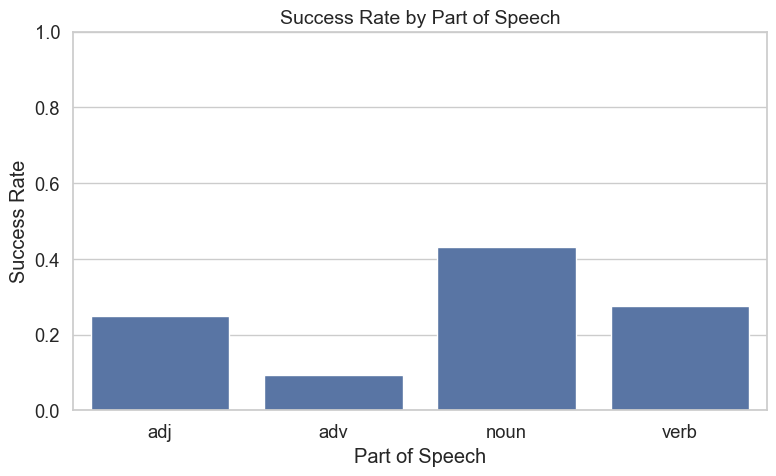

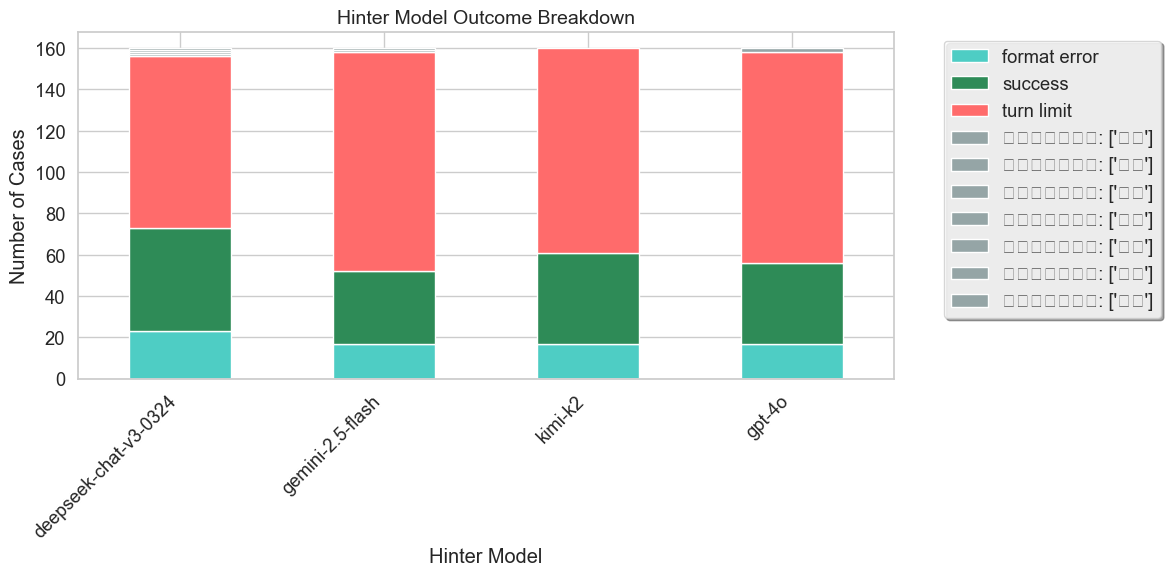

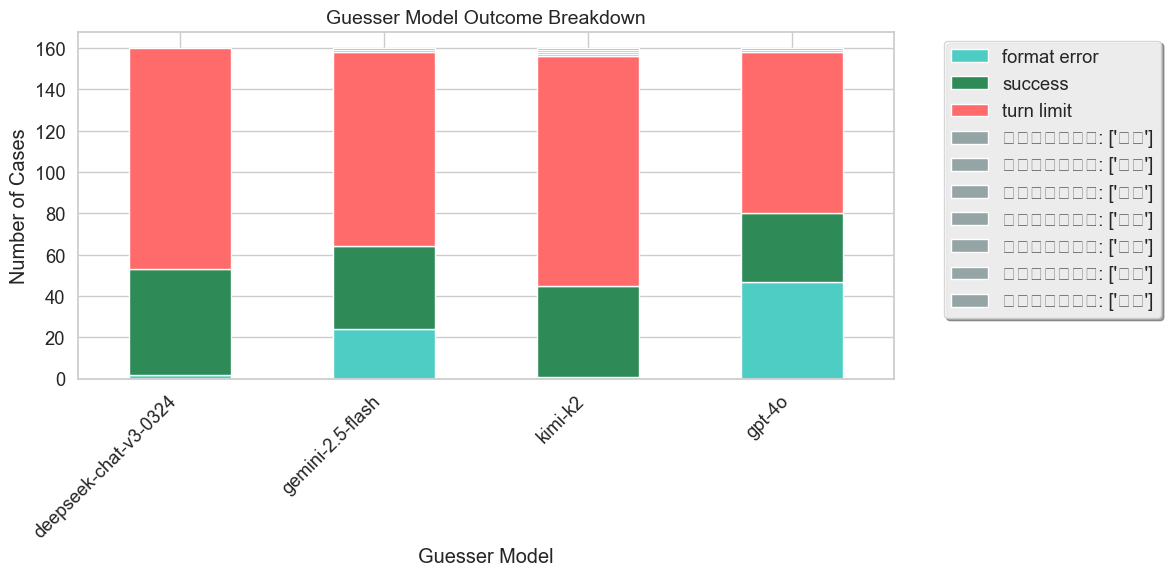

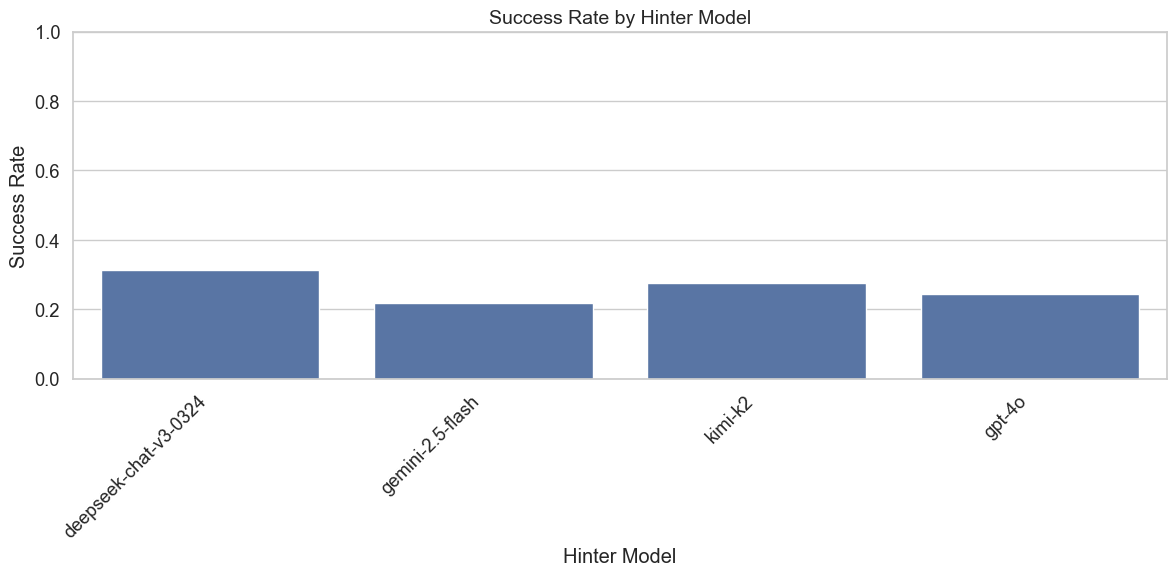

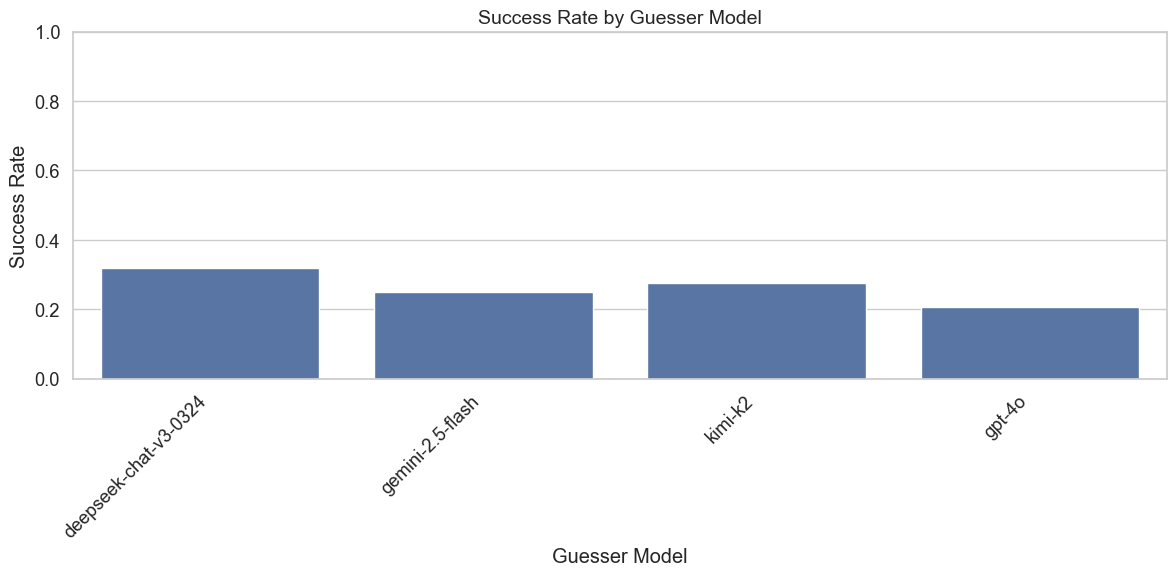

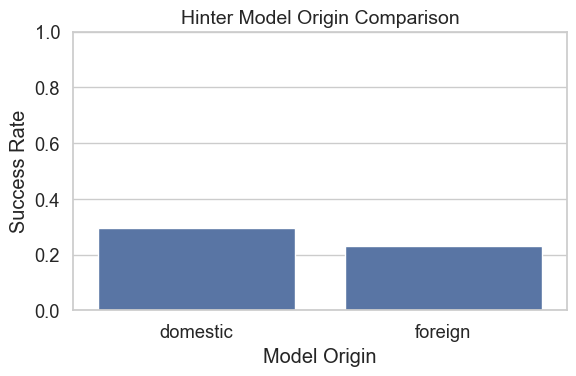

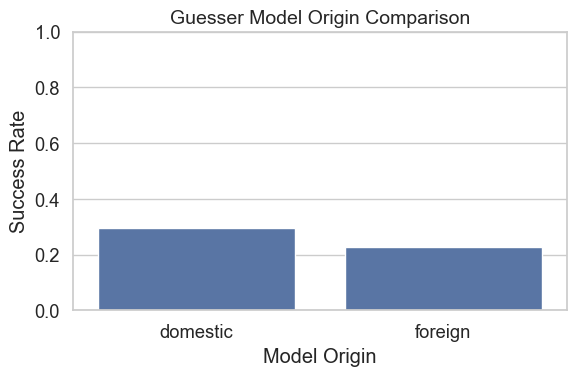

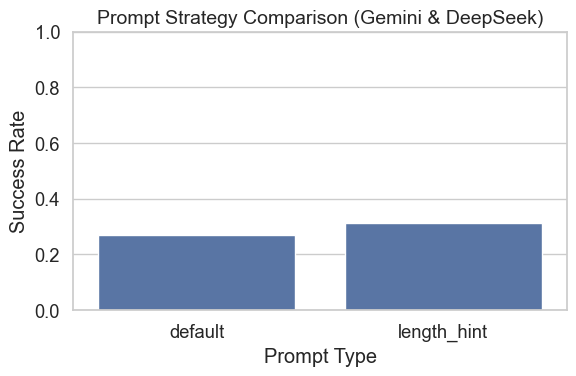

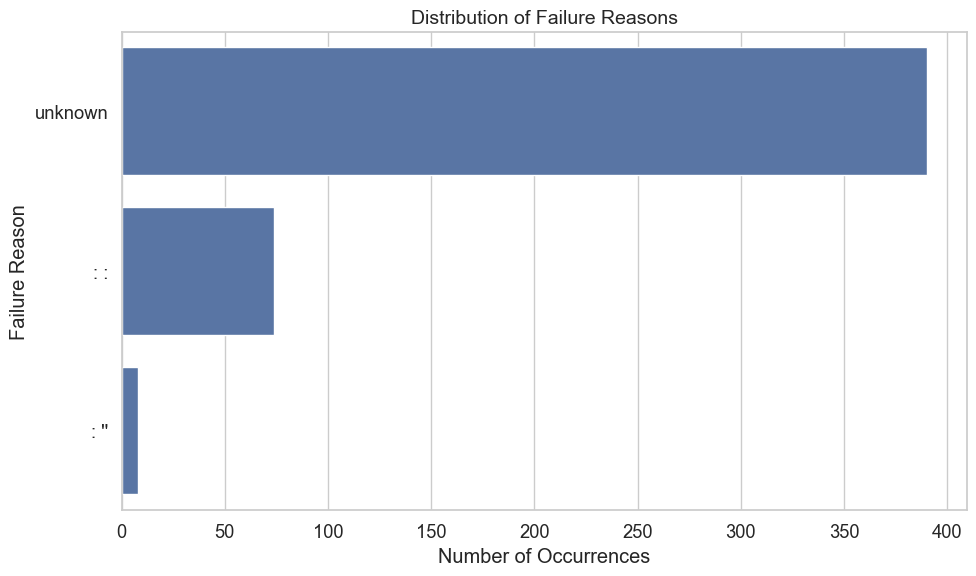

📊 EXPERIMENT ANALYSIS SUMMARY

🎯 Part-of-Speech Success Rate:
                count  success_rate
part_of_speech                     
adj               160         0.250
adv               160         0.094
noun              160         0.431
verb              160         0.275

🤖 Hinter Model Performance:
                       count  success_rate
deepseek-chat-v3-0324    160         0.312
gemini-2.5-flash         160         0.219
kimi-k2                  160         0.275
gpt-4o                   160         0.244

🎯 Guesser Model Performance:
                       count  success_rate
deepseek-chat-v3-0324    160         0.319
gemini-2.5-flash         160         0.250
kimi-k2                  160         0.275
gpt-4o                   160         0.206

🌍 Hinter Model Origin Comparison:
               count  success_rate
hinter_origin                     
domestic         320         0.294
foreign          320         0.231

🌍 Guesser Model Origin Comparison:
                count 

In [70]:
# taboo_model_analysis.ipynb

"""
Notebook: Taboo Game Experiment Analysis
Content:
1. Model performance by Part-of-Speech (POS)
2. Model-wise performance: Hinter vs Guesser
3. Comparison between domestic and foreign models
4. Prompt strategy comparison
5. Failure reason analysis
"""

# 📦 Import necessary libraries
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# 🎨 Configure matplotlib for better font support
try:
    # Try to use a more reliable font configuration
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = 'sans-serif'
    # Force matplotlib to use only ASCII characters in legends
    plt.rcParams['legend.fontsize'] = 10
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.fancybox'] = True
    plt.rcParams['legend.shadow'] = True
except:
    # Fallback configuration
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['axes.unicode_minus'] = False

# Remove Chinese font test since it's causing issues
print("🎨 Font configuration completed")

# Aesthetic setup for plots
sns.set(style="whitegrid", font_scale=1.2)

# ✅ Load main experiment data
df = pd.read_csv("results/chinese_full_experiment_20250717_222959/chinese_full_results_20250717_222959.csv")
df['success'] = df['success'].astype(bool)
df['prompt_type'] = 'default'

# ✅ Load prompt variation data (for separate analysis)
df_alt = pd.read_csv("results/chinese_full_experiment_20250717_231541/chinese_full_char_count_results_20250717_231541.csv")
df_alt['success'] = df_alt['success'].astype(bool)
df_alt['prompt_type'] = 'length_hint'

# ✅ Use main dataset for general analysis
main_df = df.copy()

# 🌍 Classify model origin
def label_model_origin(model):
    if model.startswith("openai") or model.startswith("google"):
        return "foreign"
    elif model.startswith("moonshotai") or model.startswith("deepseek"):
        return "domestic"
    else:
        return "unknown"

main_df['hinter_origin'] = main_df['hinter_model'].apply(label_model_origin)
main_df['guesser_origin'] = main_df['guesser_model'].apply(label_model_origin)

# 🎯 Analysis 1: POS success rate
pos_summary = main_df.groupby("part_of_speech")["success"].agg(['count', 'sum'])
pos_summary['success_rate'] = pos_summary['sum'] / pos_summary['count']

plt.figure(figsize=(8, 5))
sns.barplot(x=pos_summary.index, y=pos_summary['success_rate'])
plt.title("Success Rate by Part of Speech", fontsize=14)
plt.ylabel("Success Rate")
plt.xlabel("Part of Speech")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# 🎯 Analysis 2: Model-wise outcome breakdown

def classify_failure_reason(x):
    if x == True:
        return 'success'
    x = str(x).lower()
    if 'taboo' in x:
        return 'taboo violation'
    elif 'turn limit' in x or '轮数耗尽' in x:
        return 'turn limit'
    elif 'format' in x or '格式' in x:
        return 'format error'
    elif 'guess generation' in x or '猜测生成' in x:
        return 'guess generation error'
    elif 'api' in x:
        return 'api error'
    elif 'hinter_format_failure' in x:
        return 'hinter format failure'
    elif 'guesser_format_failure' in x:
        return 'guesser format failure'
    else:
        return x.strip() if x.strip() != '' else 'unknown'

main_df['hinter_outcome'] = main_df.apply(lambda row: 'success' if row['success'] else classify_failure_reason(row['failure_reason']), axis=1)
main_df['guesser_outcome'] = main_df.apply(lambda row: 'success' if row['success'] else classify_failure_reason(row['failure_reason']), axis=1)

hinter_result = main_df.groupby(['hinter_model', 'hinter_outcome']).size().unstack().fillna(0)
guesser_result = main_df.groupby(['guesser_model', 'guesser_outcome']).size().unstack().fillna(0)

# Create cleaner model names for display
def clean_model_name(model):
    """Clean model names for better display"""
    if 'openai' in model:
        return model.replace('openai/', '')
    elif 'google' in model:
        return model.replace('google/', '')
    elif 'moonshotai' in model:
        return model.replace('moonshotai/', '')
    elif 'deepseek' in model:
        return model.replace('deepseek/', '')
    return model

# Define consistent colors for outcome categories
outcome_colors = {
    'success': '#2E8B57',           # Sea Green
    'turn limit': '#FF6B6B',        # Light Red
    'format error': '#4ECDC4',      # Light Blue
    'guess generation error': '#45B7D1',  # Blue
    'api error': '#96CEB4',         # Light Green
    'taboo violation': '#FFEAA7',   # Light Yellow
    'hinter format failure': '#DDA0DD',  # Plum
    'guesser format failure': '#F0A0A0', # Light Pink
    'unknown': '#95A5A6'            # Gray
}

# Plot hinter results
fig, ax = plt.subplots(figsize=(12, 6))
hinter_result_clean = hinter_result.copy()
hinter_result_clean.index = [clean_model_name(idx) for idx in hinter_result_clean.index]

# Map colors to columns
colors = [outcome_colors.get(col, '#95A5A6') for col in hinter_result_clean.columns]
hinter_result_clean.plot(kind='bar', stacked=True, ax=ax, color=colors)
plt.title("Hinter Model Outcome Breakdown", fontsize=14)
plt.xlabel("Hinter Model")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot guesser results with same colors
fig, ax = plt.subplots(figsize=(12, 6))
guesser_result_clean = guesser_result.copy()
guesser_result_clean.index = [clean_model_name(idx) for idx in guesser_result_clean.index]

# Map colors to columns (same as hinter)
colors = [outcome_colors.get(col, '#95A5A6') for col in guesser_result_clean.columns]
guesser_result_clean.plot(kind='bar', stacked=True, ax=ax, color=colors)
plt.title("Guesser Model Outcome Breakdown", fontsize=14)
plt.xlabel("Guesser Model")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Hinter performance
hinter_perf = main_df.groupby("hinter_model")["success"].agg(['count', 'sum'])
hinter_perf['success_rate'] = hinter_perf['sum'] / hinter_perf['count']

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=[clean_model_name(idx) for idx in hinter_perf.index], y=hinter_perf['success_rate'])
plt.title("Success Rate by Hinter Model", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Success Rate")
plt.xlabel("Hinter Model")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Guesser performance
guesser_perf = main_df.groupby("guesser_model")["success"].agg(['count', 'sum'])
guesser_perf['success_rate'] = guesser_perf['sum'] / guesser_perf['count']

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=[clean_model_name(idx) for idx in guesser_perf.index], y=guesser_perf['success_rate'])
plt.title("Success Rate by Guesser Model", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Success Rate")
plt.xlabel("Guesser Model")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# 🎯 Analysis 3: Domestic vs Foreign Models
hinter_origin_perf = main_df.groupby("hinter_origin")["success"].agg(['count', 'sum'])
hinter_origin_perf['success_rate'] = hinter_origin_perf['sum'] / hinter_origin_perf['count']

guesser_origin_perf = main_df.groupby("guesser_origin")["success"].agg(['count', 'sum'])
guesser_origin_perf['success_rate'] = guesser_origin_perf['sum'] / guesser_origin_perf['count']

plt.figure(figsize=(6, 4))
sns.barplot(x=hinter_origin_perf.index, y=hinter_origin_perf['success_rate'])
plt.title("Hinter Model Origin Comparison", fontsize=14)
plt.ylabel("Success Rate")
plt.xlabel("Model Origin")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(x=guesser_origin_perf.index, y=guesser_origin_perf['success_rate'])
plt.title("Guesser Model Origin Comparison", fontsize=14)
plt.ylabel("Success Rate")
plt.xlabel("Model Origin")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# 🎯 Analysis 4: Prompt strategy comparison (Gemini & DeepSeek only)
# Merge both datasets for prompt comparison
prompt_comparison_df = pd.concat([df, df_alt], ignore_index=True)

# Filter for models that exist in both datasets
prompt_filtered = prompt_comparison_df[
    (prompt_comparison_df['hinter_model'].str.contains("gemini") | 
     prompt_comparison_df['hinter_model'].str.contains("deepseek")) &
    (prompt_comparison_df['guesser_model'].str.contains("gemini") | 
     prompt_comparison_df['guesser_model'].str.contains("deepseek"))
]

prompt_perf = prompt_filtered.groupby("prompt_type")["success"].agg(['count', 'sum'])
prompt_perf['success_rate'] = prompt_perf['sum'] / prompt_perf['count']

plt.figure(figsize=(6, 4))
sns.barplot(x=prompt_perf.index, y=prompt_perf['success_rate'])
plt.title("Prompt Strategy Comparison (Gemini & DeepSeek)", fontsize=14)
plt.ylabel("Success Rate")
plt.xlabel("Prompt Type")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# 🎯 Analysis 5: Failure reason analysis
import re

def clean_failure_reason(reason):
    """Clean and translate failure reasons"""
    if pd.isna(reason) or reason == '':
        return 'unknown'
    
    reason = str(reason).lower()
    
    # Translation mapping
    translations = {
        '轮数耗尽': 'turn limit exceeded',
        '格式验证失败': 'format validation failed',
        '猜测生成失败': 'guess generation failed',
        'taboo': 'taboo violation',
        'turn limit': 'turn limit exceeded',
        'format': 'format error',
        'api': 'api error',
    }
    
    # Remove brackets and clean
    reason = re.sub(r'[\[\]]', '', reason)
    reason = re.sub(r'[\u4e00-\u9fff]+', '', reason)  # Remove Chinese characters
    
    # Apply translations
    for chinese, english in translations.items():
        if chinese in reason:
            return english
    
    return reason.strip() if reason.strip() else 'unknown'

# Clean failure reasons
failures = main_df[~main_df['success'] & main_df['failure_reason'].notnull()].copy()
failures['failure_reason_clean'] = failures['failure_reason'].apply(clean_failure_reason)
failure_counts = failures['failure_reason_clean'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(y=failure_counts.index, x=failure_counts.values, orient="h")
plt.title("Distribution of Failure Reasons", fontsize=14)
plt.xlabel("Number of Occurrences")
plt.ylabel("Failure Reason")
plt.tight_layout()
plt.show()

# 📊 Print summary statistics
print("=" * 50)
print("📊 EXPERIMENT ANALYSIS SUMMARY")
print("=" * 50)

print("\n🎯 Part-of-Speech Success Rate:")
print(pos_summary[['count', 'success_rate']].round(3))

print("\n🤖 Hinter Model Performance:")
hinter_display = hinter_perf[['count', 'success_rate']].copy()
hinter_display.index = [clean_model_name(idx) for idx in hinter_display.index]
print(hinter_display.round(3))

print("\n🎯 Guesser Model Performance:")
guesser_display = guesser_perf[['count', 'success_rate']].copy()
guesser_display.index = [clean_model_name(idx) for idx in guesser_display.index]
print(guesser_display.round(3))

print("\n🌍 Hinter Model Origin Comparison:")
print(hinter_origin_perf[['count', 'success_rate']].round(3))

print("\n🌍 Guesser Model Origin Comparison:")
print(guesser_origin_perf[['count', 'success_rate']].round(3))

print("\n📝 Prompt Strategy Comparison (Gemini & DeepSeek):")
print(prompt_perf[['count', 'success_rate']].round(3))

print("\n❌ Failure Reason Distribution:")
print(failure_counts)

print("\n📈 Overall Statistics:")
print(f"Total games: {len(main_df)}")
print(f"Success rate: {main_df['success'].mean():.3f}")
print(f"Total successes: {main_df['success'].sum()}")
print(f"Total failures: {(~main_df['success']).sum()}")

print("\n🔄 Prompt Comparison Dataset:")
print(f"Total games: {len(prompt_comparison_df)}")
print(f"Default prompt games: {len(prompt_comparison_df[prompt_comparison_df['prompt_type'] == 'default'])}")
print(f"Length hint prompt games: {len(prompt_comparison_df[prompt_comparison_df['prompt_type'] == 'length_hint'])}")